### Community Detection

Now we apply community detection algorithms to the network data. For this part, we are trying to find communities purely based on the structure of the network.


In [2]:
from networkx.drawing.nx_pydot import graphviz_layout
from networkx.algorithms import community
from networkx.algorithms.community import modularity
import networkx as nx

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import time

%matplotlib inline

In [3]:
# Reading MS graph people API data

ms_people = pd.read_csv('passive_ms_new.csv')
len(ms_people)


548

In [4]:
len(ms_people['Employee ID_sender'].unique())

91

In [5]:
G =nx.from_pandas_edgelist(ms_people, source="Employee ID_sender", target="Employee ID_receiver", 
                           edge_attr=["relevanceScore"] , create_using=nx.Graph())
len(list(G.nodes()))

155

In [6]:
hr_df = pd.read_csv('passive_hr_new.csv')
hr_df.head()

,Employee ID,On Site Frequency,Position Title,Date in service,Business Unit level 1,Business Unit level 2
0,3022906,Fully Remote,Sr. Software Development Engineer II,2022-07-18,Corporate,Engineering - Brand 2
1,3031509,Fully Remote,Sr. Digital Marketing Specialist II,2022-12-05,Corporate,Marketing
2,2003115,Hybrid,Social Media Specialist I,2021-03-01,Brand 2,Marketing - Brand 2
3,2001173,Hybrid,Principal Software Architect,2010-06-14,Corporate,Technology
4,3023646,Fully Remote,Product Specialist II,2022-08-01,Corporate,Engineering - Brand 2


In [76]:
hr_df['Business Unit level 2'].unique()

array(['Engineering - Brand 2', 'Marketing', 'Marketing - Brand 2',
       'Technology', 'Legal', 'Product Merchandising - Brand 2',
       'Finance', 'Customer Service - Brand 2', 'Manufacturing-Brand 1',
       'Leadership', 'Environmental Health & Safety', 'Supply Chain',
       'Field-Schools', 'Consumer', 'Sales-Brand 3', 'Program Management',
       'Sales - Brand 2', 'Human Resources',
       'Enterprise Information Systems'], dtype=object)

In [77]:

abr = []
for i in list(hr_df['Business Unit level 2']):
    if i == 'Customer Service - Brand 2':
        abr.append('CS_SF')
    elif i == 'Engineering - Brand 2':
        abr.append('ENG_SF')
    elif i == 'Marketing - Brand 2':
        abr.append('MKT_SF')
    elif i == 'Product Merchandising - Brand 2':
        abr.append('PM_SF')
    elif i == 'Sales - Brand 2':
         abr.append('Sales_SF')
    elif i == 'Leadership':
         abr.append('Leadership')
    elif i == 'Marketing':
         abr.append('MKT_Corp')
    elif i == 'Technology':
        abr.append('Tech_Corp')
    elif i == 'Legal':
        abr.append('Legal_Corp')
    elif i == 'Finance':
        abr.append('Finance_Corp')
    elif i == 'Supply Chain':
        abr.append('SPC_Crop')
    elif i == 'Human Resources':
        abr.append('HR_Corp')
    elif i == 'Enterprise Information Systems':
        abr.append('EIS_Corp')
    elif i == 'Field-Schools':
        abr.append('FS_Lt')
    elif i == 'Sales-Brand 3':
        abr.append('Sales_Lt')
    elif i == 'Manufacturing-Brand 1':
        abr.append('MF_Op')
    elif i == 'Environmental Health & Safety':
        abr.append('EnHS_Op')
    elif i == 'Program Management':
        abr.append('PrgM_Op')
    else:
        abr.append('Consumer_SHC')


hr_df['team_abr'] = abr

### Setting Attributes for each node in the Graph

Each node in the graph contains the attributes:

* "Employee ID": the organization employee's ID 
* "Team_L1:" the organization business units at level 1
* "Team_L2:" the organization business units at level 2

In [8]:


attrs = {}
for i in range(len(hr_df)):
    attrs[hr_df['Employee ID'][i]] = {'Employee ID': hr_df['Employee ID'][i], 
                                      'Team_L1' : hr_df['Business Unit level 1'][i],
                                      'Team_L2' : hr_df['Business Unit level 2'][i],
                                      'Abbr' : hr_df['team_abr'][i]
                                      }

attrs
nx.set_node_attributes(G, attrs)

The edges contain the MS graph people API relevance score as a edge attribute

In [9]:
list(G.edges(data=True))[0:5]

[(3007231, 2003018, {'relevanceScore': 1317.0}),
 (3007231, 2003155, {'relevanceScore': 675.0}),
 (3007231, 2003148, {'relevanceScore': 324.0}),
 (3007231, 2003133, {'relevanceScore': 291.0}),
 (3007231, 3022260, {'relevanceScore': 285.0})]

##### Extract the largest connected component from the graph.

In [10]:
# Extract the largest connected component of the original dataset
G = G.subgraph(max(nx.connected_components(G), key=len))
# stores the number of nodes in this graph
N = G.number_of_nodes()
N

155

Conclusiton: The result shows that there is a large single component (the giant component) that fills the network

##### Treat teams/departments as communityes

First, we think of team domains as communities

In [11]:
# set of unique community labels
list_of_communities = set() # set of unique community labels
# number of communities in total


for i in range(155):
    domain = list(G.nodes(data=True))[i][1]['Team_L2']
    if domain not in list_of_communities:
        list_of_communities.update([domain])
N = len(list_of_communities)
N
list_of_communities

{'Consumer',
 'Customer Service - Brand 2',
 'Engineering - Brand 2',
 'Enterprise Information Systems',
 'Environmental Health & Safety',
 'Field-Schools',
 'Finance',
 'Human Resources',
 'Leadership',
 'Legal',
 'Manufacturing-Brand 1',
 'Marketing',
 'Marketing - Brand 2',
 'Product Merchandising - Brand 2',
 'Program Management',
 'Sales - Brand 2',
 'Sales-Brand 3',
 'Supply Chain',
 'Technology'}

##### How many nodes does each community have?

In [12]:
from collections import Counter

# a Counter object with the format {community_name: number_of_nodes}
cnt = Counter()
for name in [list(G.nodes(data=True))[i][1]['Team_L2'] for i in range(155)]:
    cnt[name] += 1
dict_num_community = cnt
dict_num_community

Counter({'Engineering - Brand 2': 34,
         'Customer Service - Brand 2': 29,
         'Manufacturing-Brand 1': 18,
         'Marketing - Brand 2': 16,
         'Technology': 12,
         'Marketing': 9,
         'Product Merchandising - Brand 2': 8,
         'Supply Chain': 4,
         'Sales - Brand 2': 3,
         'Finance': 3,
         'Human Resources': 3,
         'Field-Schools': 3,
         'Legal': 3,
         'Leadership': 2,
         'Enterprise Information Systems': 2,
         'Environmental Health & Safety': 2,
         'Consumer': 2,
         'Program Management': 1,
         'Sales-Brand 3': 1})

In [13]:
hr_df['team_abr'].unique()

array(['ENG_SF', 'MKT_Corp', 'MKT_SF', 'Tech_Corp', 'Legal_Corp', 'PM_SF',
       'Finance_Corp', 'CS_SF', 'Consumer_SHC', 'Leadership', 'EnHS_Op',
       'SPC_Crop', 'FS_Lt', 'Sales_Lt', 'PrgM_Op', 'Sales_SF', 'HR_Corp',
       'EIS_Corp'], dtype=object)

In [14]:
tuples = []
for i in list(dict_num_community.keys()):
    df = hr_df[hr_df['Business Unit level 2'] == i]
    l = tuple(df['Employee ID'])
    tuples.append(l)
tuples
communities = set(map(frozenset, tuples))

In [15]:
hr_df['team_abr'].value_counts()

team_abr
ENG_SF          34
CS_SF           29
Consumer_SHC    20
MKT_SF          16
Tech_Corp       12
MKT_Corp         9
PM_SF            8
SPC_Crop         4
Finance_Corp     3
Legal_Corp       3
HR_Corp          3
FS_Lt            3
Sales_SF         3
Leadership       2
EIS_Corp         2
EnHS_Op          2
Sales_Lt         1
PrgM_Op          1
Name: count, dtype: int64

In [17]:
def subset1(level2):
    sub = hr_df[hr_df['Business Unit level 2'] == str(level2)]
    return sub


def subset(level1):
    sub = hr_df[hr_df['Business Unit level 1'] == str(level1)]
    return sub

slr = subset1('Leadership')
seng = subset1('Engineering - Brand 2')
smt = subset1('Marketing - Brand 2')
spm = subset1('Product Merchandising - Brand 2')
ssale = subset1('Sales - Brand 2')
scs = subset1('Customer Service - Brand 2')

opera = subset('Operations')
lifet = subset('Brand 3')
corp_1 = subset('Corporate')
# exclude brand 2 enginnering and vp form corporate

corp_2 = corp_1[corp_1['Business Unit level 2'] != 'Engineering - Brand 2']
corp = corp_2[corp_2['Employee ID'] != 3040598]
shfycs = subset('Brand 1 Consumer')

In [18]:

tuples1 = []
for i in [seng, smt, spm, ssale, scs, opera, lifet, corp, shfycs, slr]:
    l = tuple(i['Employee ID'])
    tuples1.append(l)
#communities_1 = set(map(frozenset, tuples1))

nodes_slr = list(slr['Employee ID'])
nodes_seng = list(seng['Employee ID'])
nodes_smt = list(smt['Employee ID'])
nodes_spm = list(spm['Employee ID'])
nodes_ssale = list(ssale['Employee ID'])
nodes_scs = list(scs['Employee ID'])
nodes_ope = list(opera['Employee ID'])
nodes_lt = list(lifet['Employee ID'])
nodes_cor = list(corp['Employee ID'])
nodes_shc = list(shfycs['Employee ID'])


##### Measures of Partition Quality 
We used 5 ways to measure the quality of a partition: modularity, coverage, performance, separability, and density, which we modified from SIADS NetWork Analysis Course

Defining a helper function avg_measure(G, communities, measure) that computes the average value for a given measure over all communities in a graph.

In [19]:
# Calculate the average value of a given measure across communities in a graph.
def avg_measure(G, communities, measure):
    sum_ = 0
    for comm in communities:
        sum_ += measure(G, comm)
    return sum_ / len(communities)

Defining a function to measure the separability for a single community -- measure the ratio of intra-community to inter-community edges.

In [20]:
def separability_one_community(G, community):
    community_graph = G.subgraph(community)
    intra_num = community_graph.number_of_edges()
    inter_num = len(G.edges(community)) - intra_num
    
    # assign separability to it and return
    if inter_num == 0:
        result = intra_num
    else:
        result = intra_num/inter_num
    return result

Then, we can use avg_measure(G, communities, separability_one_community) to measure the separability of a partition.

Defining a function to measure the density of a single community -- the fraction of intra-community edges out of all possible edges.

In [21]:
def density_one_community(G, community):
    # If the community has only one node, just return 1
    if len(community) == 1: 
        return 1
    else:
        community_graph = G.subgraph(community)
        intra_num = community_graph.number_of_edges()
        values = community_graph.number_of_nodes()
        result = intra_num/(1/2*values*(values-1))
        # assign density to it and return 
        return result

Using avg_measure(G, communities, density_one_community) to measure the density of a partition.

##### What is the modularity, coverage, performance, density, and separability of this network using the team domain as a partition?

* The Modularity: A measure of the structure of networks or graphs which measures the strength of division of a network into modules. Networks with high modularity have dense connections between the nodes within modules but sparse connections between nodes in different modules.

* The coverage of a partition: The ratio of the number of intra-community edges to the total number of edges in the graph.

* The performance of a partition: The number of intra-community edges plus inter-community non-edges divided by the total number of potential edges.

* The separability of a community: The ratio of intra-community edges to inter-community edges.

* The density of a community: The fraction of intra-community edges out of all possible edges.

##### Calculating the modularity, coverage, performance, density, and separability of this network that using the team domain as a partition

In [22]:
def q_measure(G, communities):
    mod = nx.algorithms.community.modularity(G, communities)
    quality = nx.algorithms.community.partition_quality(G, communities)
    cov = quality[0]
    perf = quality[1]
    sep = avg_measure(G, communities, separability_one_community)
    den = avg_measure(G, communities, density_one_community)
    return {'mod':mod, 'cov':cov, 'perf': perf, 'sep':sep, 'den':den}#mod, cov, perf, sep, den

In [23]:

communities_list = []
for i in list(list_of_communities):
    group = set()
    for j in range(155):
        if list(G.nodes(data=True))[j][1]['Team_L2'] == i:
            group.update([list(G.nodes(data=True))[j][1]['Employee ID']])
    communities_list.append(group)
mod = nx.algorithms.community.modularity(G, communities_list)
quality = nx.algorithms.community.partition_quality(G, communities_list)
cov = quality[0]
perf = quality[1]
sep = avg_measure(G, communities_list, separability_one_community)
den = avg_measure(G, communities_list, density_one_community)


In [24]:
# Team domain's modularity, coverage, performance, density, and separability
team_domain = q_measure(G, communities_list)
t_mod = team_domain['mod']
t_cov = team_domain['cov']
t_perf = team_domain['perf']
t_sep = team_domain['sep']
t_den = team_domain['den']
print(t_mod, t_cov, t_perf, t_sep, t_den)

0.2909451795841211 0.4826086956521739 0.8817762882279011 0.15264931532244552 0.2254304856738934


#### Community Detection Algorithms

We apply community detection algorithms to the Brand 2 organization network graph. For this part, we are trying to find communities purely based on the structure of the network.

The community detection algorithms, we are going to apply, including the Girvan-Newman, the label propagation algorithm, and the K-Clique. We will begin with the Girvan-Newman algorithm and pick the partition that results in the largest modularity, then the label propagation. Lastly, it would be the K-Clique.

##### Using Girvan_newman to find communities

Girvan-Newman Algorithm: for Community Detection, the communities in a graph are discovered by iteratively removing the edges of the graph according to the edge betweenness centrality value. The edge with the highest edge betweenness is removed first.


In [25]:
communities = list(nx.community.girvan_newman(G))

# Modularity -> measures the strength of division of a network into modules
modularity_df = pd.DataFrame(
    [
        [k + 1, nx.community.modularity(G, communities[k])]
        for k in range(len(communities))
    ],
    columns=["k", "modularity"],
)

In [26]:
len(communities[10])

12

In [27]:
#len(communities[54])
from random import randint
color = []

for i in range(14):
    color.append('#%06X' % randint(0, 0xFFFFFF))

In [28]:
# function to create node colour list
def create_community_node_colors(graph, communities):
    number_of_colors = len(communities[0])
    #colors = ["#D4FCB1", "#CDC5FC", "#FFC2C4", "#F2D140", "#BCC6C8"][:number_of_colors]
    colors = color[:number_of_colors]
    node_colors = []
    for node in graph:
        current_community_index = 0
        for community in communities:
            if node in community:
                node_colors.append(colors[current_community_index])
                break
            current_community_index += 1
    return node_colors


In [29]:
abbr = nx.get_node_attributes(G, "Abbr")


In [30]:
def visualize_communities(graph, communities, i):
    node_colors = create_community_node_colors(graph, communities)
    modularity = round(nx.community.modularity(graph, communities), 6)
    title = f"Community Visualization of {len(communities)} communities with modularity of {modularity}"
    pos = nx.spring_layout(graph, k=0.3, iterations=50, seed=2)
    plt.subplot(2, 1, i)
    plt.title(title, fontsize=20)
    nx.draw(
        graph,
        pos=pos,
        node_size=250,
        node_color=node_colors,
        edge_color= 'skyblue',
        with_labels=True,
        labels = abbr,
        font_size=8,
        font_weight = 'bold',
        font_color="black",
    )

In [31]:
len(communities[6])

8

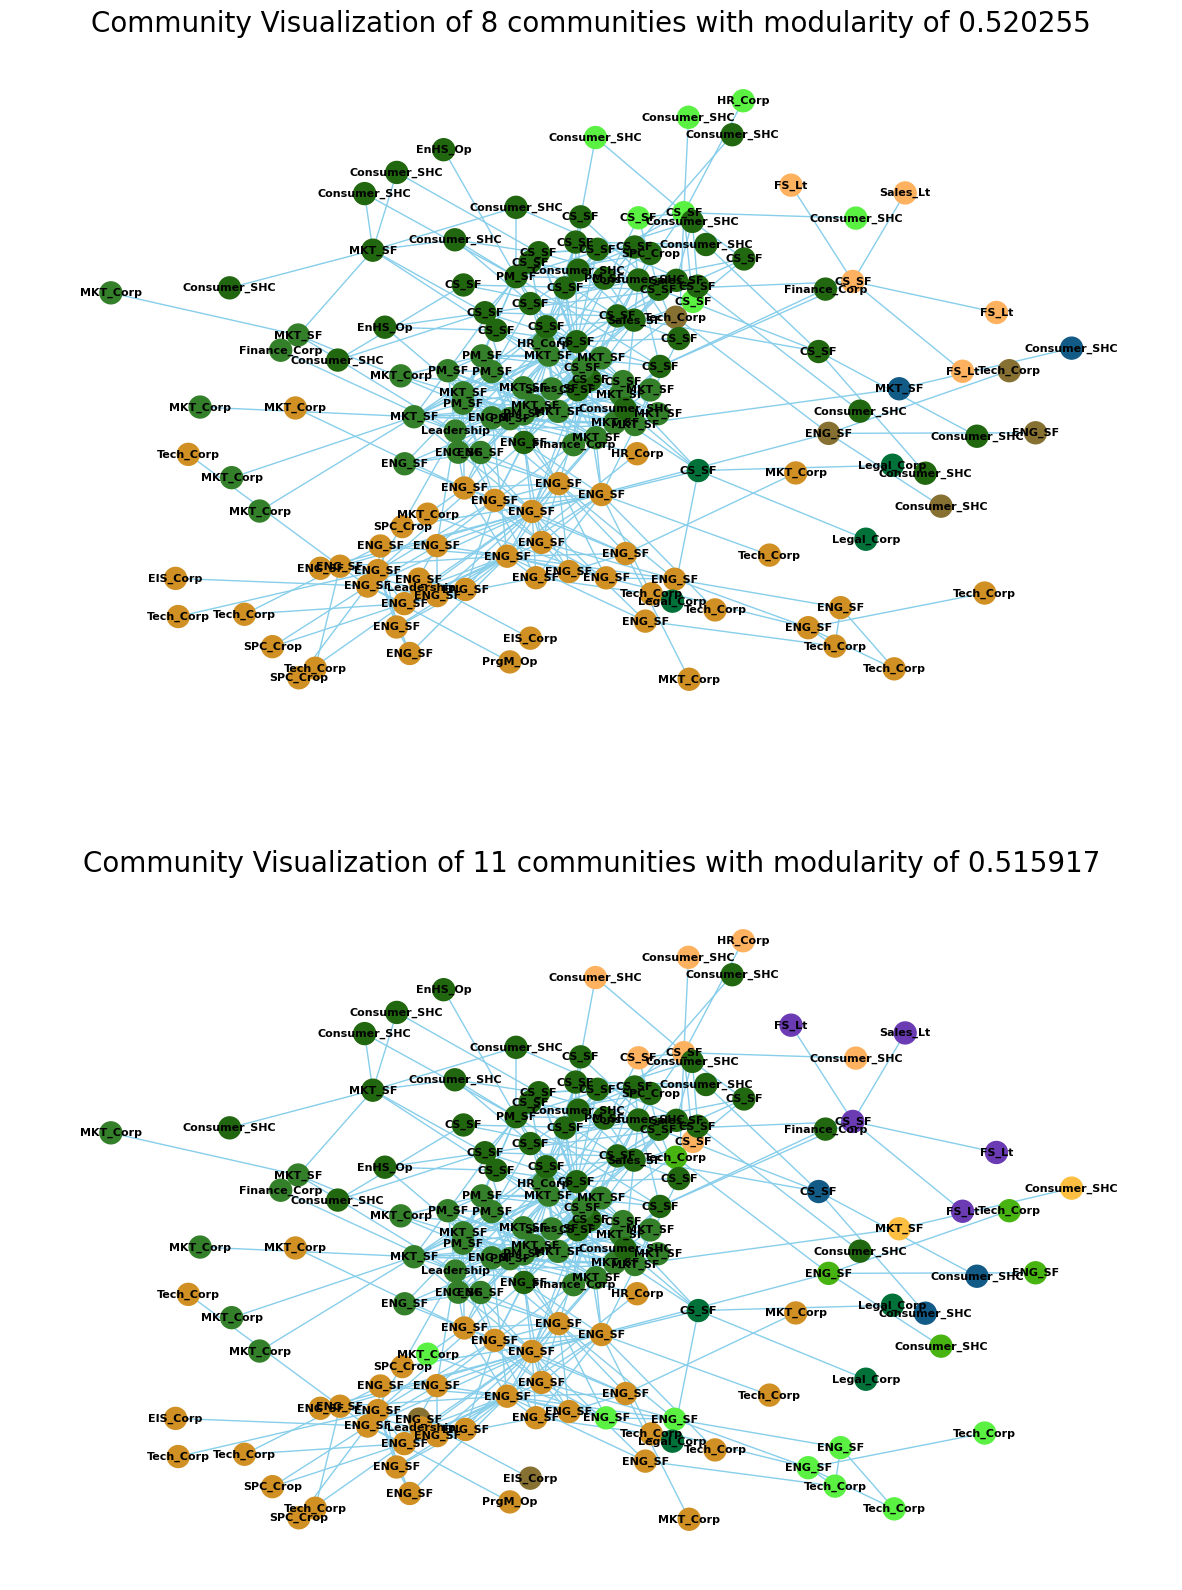

In [32]:
fig, ax = plt.subplots(2, figsize=(15, 20))

# Plot graph with colouring based on communities
visualize_communities(G, communities[6], 1)
visualize_communities(G, communities[9], 2)


plt.show()

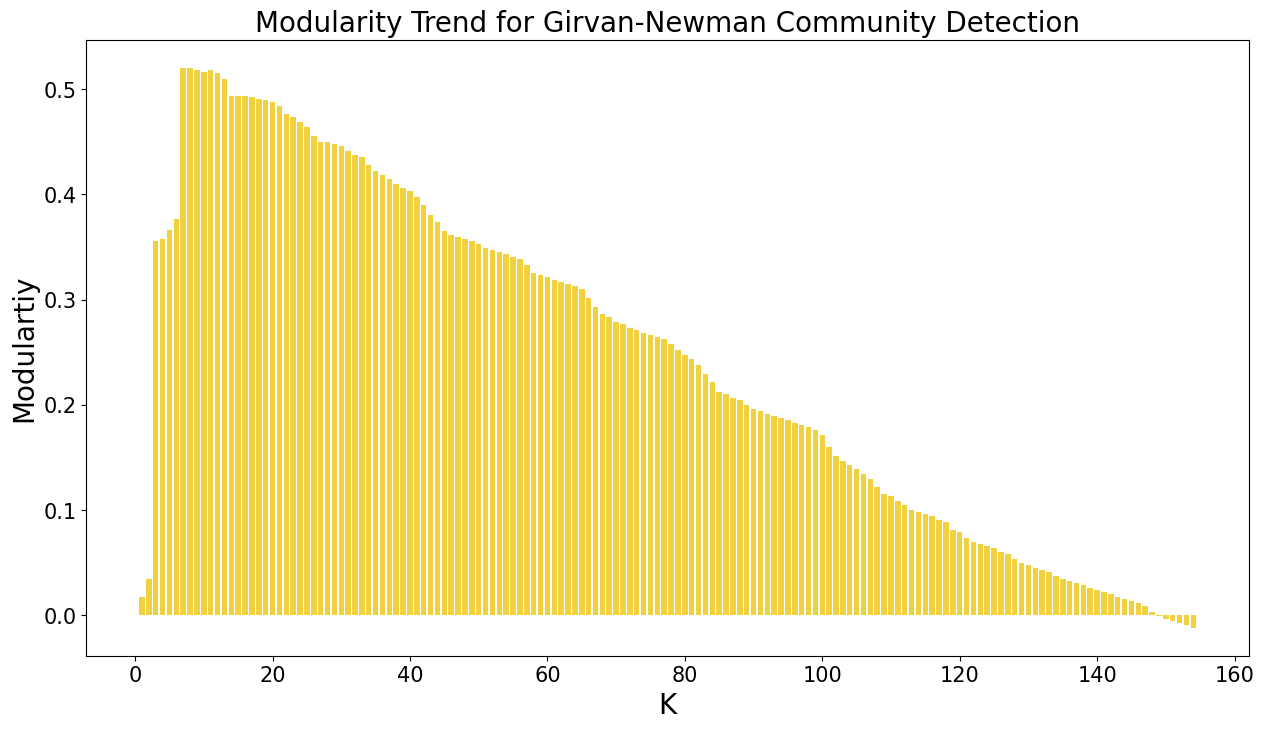

In [33]:
# Plot change in modularity as the important edges are removed

fig = plt.figure(figsize = (15, 8))

# creating the bar plot
plt.bar(x = list(modularity_df['k']), 
        height = list(modularity_df["modularity"]), 
        color ="#F2D140", 
        )

plt.xlabel("K", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("Modulartiy", fontsize=20)
plt.title("Modularity Trend for Girvan-Newman Community Detection", fontsize=20)
plt.show()

##### Community detection result:

The result shows that dividing whole network into 8 communityies has a highest modularity of 0.52

In [34]:

start = time.time()

communities_generator = community.girvan_newman(G)
next_level_communities = ()
next_lists = []
mod_scores = []

while True:
    try:
        next_level_communities = next(communities_generator)
        mod = modularity(G, next_level_communities)
        next_lists.append(next_level_communities)
        mod_scores.append(mod)
    except StopIteration:
        break

end = time.time()
print("%.2f min ellapsed." % ((end - start)/60))

id_max = np.argmax(mod_scores)
max_mod_community = next_lists[id_max]

0.14 min ellapsed.


In [35]:
num_max_mod_communities = len(max_mod_community)
gn = q_measure(G, max_mod_community) 
dic = {}
dic['Method name'] = ['Girvan Newman', 'Greedy modularity maximization', 'Label propogation', 'Team domain']
dic['num_community'] = [num_max_mod_communities, 0, 0, 0]
dic['modularity'] = [gn['mod'], 0, 0, 0]
dic['coverage'] = [gn['cov'], 0, 0, 0]
dic['performance'] = [gn['perf'], 0, 0, 0]
dic['density'] = [gn['den'], 0, 0, 0]
dic['separability'] = [gn['sep'], 0, 0, 0]
dic

{'Method name': ['Girvan Newman',
  'Greedy modularity maximization',
  'Label propogation',
  'Team domain'],
 'num_community': [8, 0, 0, 0],
 'modularity': [0.5202551984877127, 0, 0, 0],
 'coverage': [0.8195652173913044, 0, 0, 0],
 'performance': [0.778718056137411, 0, 0, 0],
 'density': [0.3748370509165738, 0, 0, 0],
 'separability': [1.9918038140020897, 0, 0, 0]}

##### Using Clauset Newman Moore greedy modularity maximization, find a partition of the network and compute the number of communities in the partition and its modularity, coverage, performance, density, and separability.

In [36]:
gred_partition = nx.algorithms.community.greedy_modularity_communities(G)
num_community = len(list(gred_partition))
ahc_partition = list(gred_partition)
gred = q_measure(G, ahc_partition) 

dic['num_community'][1] = num_community
dic['modularity'][1] = gred['mod']
dic['coverage'][1] = gred['cov']
dic['performance'][1] = gred['perf']
dic['density'][1] = gred['den']
dic['separability'][1] = gred['sep']
dic

{'Method name': ['Girvan Newman',
  'Greedy modularity maximization',
  'Label propogation',
  'Team domain'],
 'num_community': [8, 10, 0, 0],
 'modularity': [0.5202551984877127, 0.5203426275992438, 0, 0],
 'coverage': [0.8195652173913044, 0.7913043478260869, 0, 0],
 'performance': [0.778718056137411, 0.8162547130289066, 0, 0],
 'density': [0.3748370509165738, 0.4282830893072013, 0, 0],
 'separability': [1.9918038140020897, 1.518683155080214, 0, 0]}

##### Finding a partition of the network with the label propagation algorithm and compute the number of communities in the partition and its modularity, coverage, performance, denisty, and separability.

In [37]:
lp_generator = nx.algorithms.community.label_propagation.label_propagation_communities(G)
lp_partition = list(lp_generator)
num_community = len(lp_partition)
lp = q_measure(G, lp_partition) 


dic['num_community'][2] = num_community
dic['modularity'][2] = lp['mod']
dic['coverage'][2] = lp['cov']
dic['performance'][2] = lp['perf']
dic['density'][2] = lp['den']
dic['separability'][2] = lp['sep']
dic

{'Method name': ['Girvan Newman',
  'Greedy modularity maximization',
  'Label propogation',
  'Team domain'],
 'num_community': [8, 10, 13, 0],
 'modularity': [0.5202551984877127, 0.5203426275992438, 0.5125378071833647, 0],
 'coverage': [0.8195652173913044, 0.7913043478260869, 0.7608695652173914, 0],
 'performance': [0.778718056137411, 0.8162547130289066, 0.839882697947214, 0],
 'density': [0.3748370509165738, 0.4282830893072013, 0.5074153488787636, 0],
 'separability': [1.9918038140020897,
  1.518683155080214,
  1.3579651715449843,
  0]}

In [38]:
#0.290945179584121 0.4826086956521739 0.8817762882279011 0.15264931532244552 0.2254304856738934

dic['num_community'][3] = 10
dic['modularity'][3] = 0.290945
dic['coverage'][3] = 0.482608
dic['performance'][3] = 0.881776
dic['density'][3] = 0.152649
dic['separability'][3] = 0.225430
dic

{'Method name': ['Girvan Newman',
  'Greedy modularity maximization',
  'Label propogation',
  'Team domain'],
 'num_community': [8, 10, 13, 10],
 'modularity': [0.5202551984877127,
  0.5203426275992438,
  0.5125378071833647,
  0.290945],
 'coverage': [0.8195652173913044,
  0.7913043478260869,
  0.7608695652173914,
  0.482608],
 'performance': [0.778718056137411,
  0.8162547130289066,
  0.839882697947214,
  0.881776],
 'density': [0.3748370509165738,
  0.4282830893072013,
  0.5074153488787636,
  0.152649],
 'separability': [1.9918038140020897,
  1.518683155080214,
  1.3579651715449843,
  0.22543]}

##### Create and print a pandas DataFrame where each row represents a community detection algorithm and each column is a quality measure.

In [39]:
compare = pd.DataFrame.from_dict(dic)

compare

,Method name,num_community,modularity,coverage,performance,density,separability
0,Girvan Newman,8,0.520255,0.819565,0.778718,0.374837,1.991804
1,Greedy modularity maximization,10,0.520343,0.791304,0.816255,0.428283,1.518683
2,Label propogation,13,0.512538,0.760870,0.839883,0.507415,1.357965
3,Team domain,10,0.290945,0.482608,0.881776,0.152649,0.225430


##### Conclusion:

 It seems that the different quality measures may result in different algorithm that could help us find a good partition. From the result of this table, we find that "Greedy modularity maximization" and 'Girvan Newman' methods both performs well on modularity quality measurements with approximately highest score of 0.52. However, the results of performance and density show that the "Label propogation" method has the highest score in these two quality measurements. 

 Finally, for coverrage quality measure, the "Girvan Newman" has outperformed others because it has lowest communities of 8. 
 
 Based on the results of five different quality measurements, the team domain does not appear to be a good way to partition the network into communities. Because the "team Domain" not only has the lowest socre of 0.29 in the modularity comparing to other 3 different algorithms, but the "Team Domain" partition also does not perform well on other quality measurements, such as the density quality measure with the score of 0.15(lowest), the coverage measure with score of 0.48 (the lowest) and the separability measure with the score of 0.225 (the lowest), except the performance meaure with the score of 0.88 (the 1st place). Thus, comparing the quality scores of the partition with other three algorithms, we can conclude that the "Team Domain" partition method is not a best way for community network partition, which means that there are some subegroup in our network, and they have strong relationship among them which is beyoind the team domain limitation.

 

##### Cliques
In the densest neighborhoods of a network, it is sometimes possible to find groups of nodes that are all connected to each other. Such groups are called cliques.

In community detection, a **maximum clique** refers to the largest subset of vertices in a graph where every pair of vertices is connected by an edge. This means that within this subset, every member is directly connected to every other member, forming a complete subgraph.

##### Key Points about Maximum Cliques:
1. **Definition**: A clique is a subset of vertices such that every two distinct vertices are adjacent. A maximum clique is the largest possible clique in the graph².

2. **Applications**: Maximum cliques are used in various applications, including social network analysis, where they help identify tightly-knit groups or communities³.


In [40]:
cliques = list(nx.find_cliques(G))

Text(0.5, 1.0, 'The maximal clique')

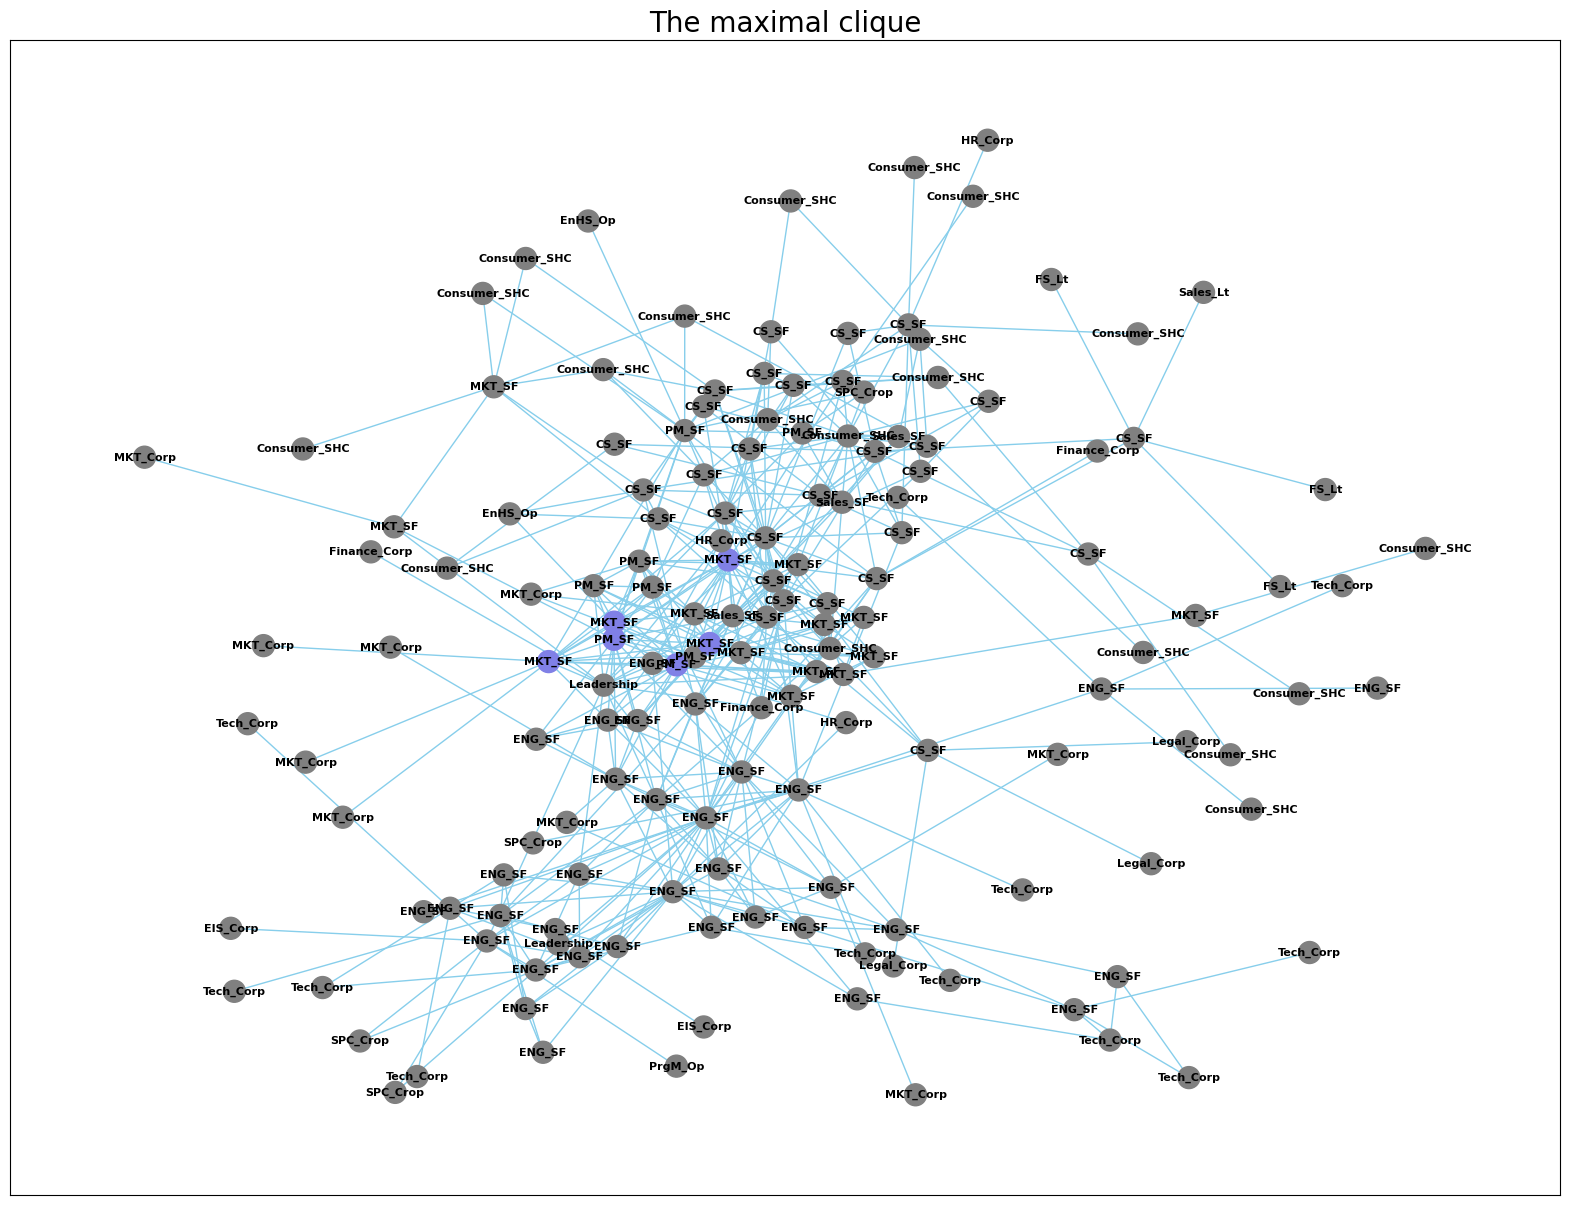

In [41]:
#Find max clique
max_clique = max(cliques, key=len)


fig = plt.figure(figsize = (20, 15))
# Visualize maximum clique
node_color = [(0.5, 0.5, 0.5) for v in G.nodes()]
pos = nx.spring_layout(G, k=0.3, iterations=50, seed=2)
for i, v in enumerate(G.nodes()):
    if v in max_clique:
        node_color[i] = (0.5, 0.5, 0.9)
nx.draw_networkx(G,
        pos=pos,
        node_size=250,
        node_color=node_color,
        edge_color= 'skyblue',
        with_labels=True,
        labels = abbr,
        font_size=8,
        font_weight = 'bold',
        font_color="black",)
plt.title('The maximal clique', fontsize = 20)

In [44]:
#tightly-knit groups

tk_group = hr_df[hr_df['Employee ID'].isin(max_clique)]
tk_group

,Employee ID,On Site Frequency,Position Title,Date in service,Business Unit level 1,Business Unit level 2,team_abr
49,3042370,Fully Remote,"Director, Growth - Brand 2",2023-11-27,Brand 2,Marketing - Brand 2,MKT_SF
59,3042755,Fully Remote,"Manager, CRM",2024-01-08,Brand 2,Marketing - Brand 2,MKT_SF
61,2003018,Hybrid,"Sr. Manager, Merchandising",2015-03-04,Brand 2,Product Merchandising - Brand 2,PM_SF
111,2003133,Hybrid,"Sr. Manager, Brand Marketing",2012-06-18,Brand 2,Marketing - Brand 2,MKT_SF
115,2003155,Hybrid,"Director, Business Line",2018-11-05,Brand 2,Product Merchandising - Brand 2,PM_SF
145,3045090,Hybrid,CRM Manager II,2024-07-08,Brand 2,Marketing - Brand 2,MKT_SF


##### Insight:

A maximum clique in this network would represent a group of employees where each person directly collaborates with every other person in the group. Identifying such cliques can help in understanding the core teams or highly collaborative groups within the organization.

From the maxumum cluque network graph and tt_group dataframe, we identified a tightly-knit group that is comprised of meneger level of employees from both Marketing and Product Merchandising teams, including position title as Director, Growth - Brand 2, Manager, CRM, Sr. Manager, Merchandising, Sr. Manager, Brand Marketing, Director, Business Line, CRM Manager II.

##### K-Core

In larger networks, k-cores can be a practical alternative for finding dense regions. A k-core is created by removing all nodes of degree less than k from a network. The number k can be anything you choose. The larger k is, the more nodes will be stripped away.

A **k-core** is a subgraph in which every vertex(node) has at least \( k \) connections (degree) to other vertices(nodes) within the subgraph. It helps identify the most interconnected and cohesive parts of a network. Here are some key points about k-cores:

1. **Definition**: A k-core is a maximal subgraph where each vertex has a degree of at least \( k \)¹². This means that within this subgraph, every node is connected to at least \( k \) other nodes.

2. **Identification**: To find a k-core, you iteratively remove all vertices with a degree less than \( k \) until no more vertices can be removed.

3. **Applications**:
   - **Community Detection**: K-cores can help identify tightly-knit communities within larger networks¹.
   - **Network Robustness**: Analyzing k-cores can provide insights into the robustness and resilience of a network.
   - **Influence Spread**: In social networks, k-cores can highlight influential groups or individuals who are well-connected.


In [61]:
#sorted(G.degree, key=lambda x: x[1], reverse=True)

Text(0.5, 1.0, '2-core and 6-core in the Brand 2 Organization network')

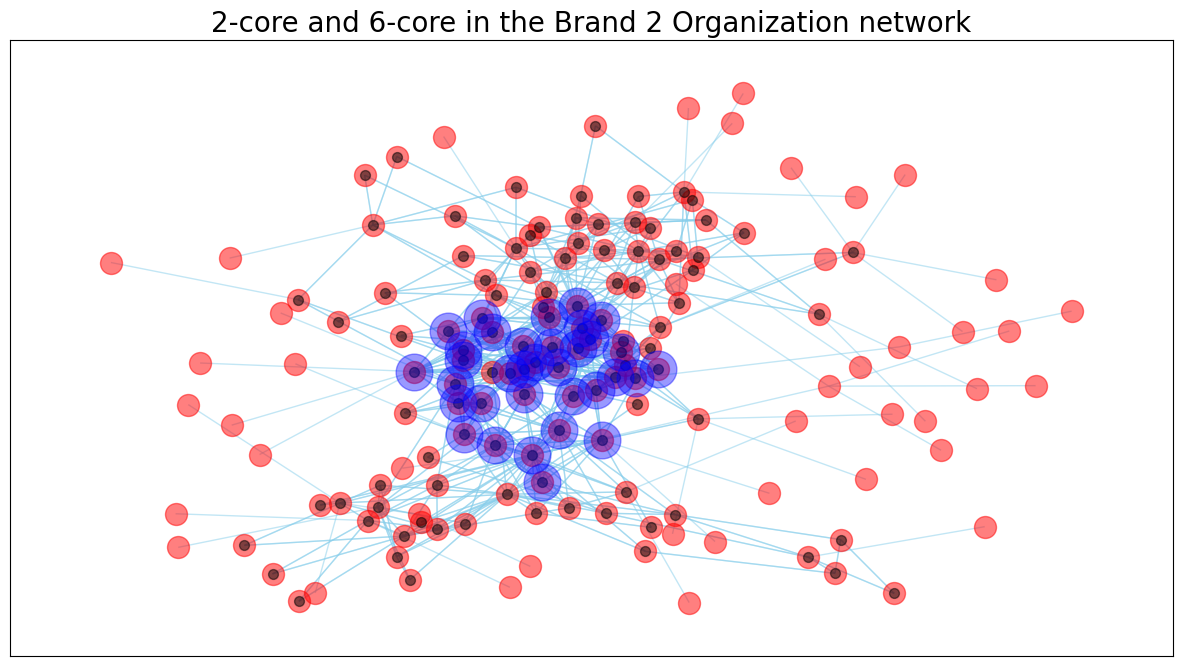

In [60]:
# Find k-cores
G_core_2 = nx.k_core(G, 2)
G_core_6 = nx.k_core(G, 6)

# Visualize network and k-cores
fig = plt.figure(figsize = (15, 8))
nx.draw_networkx(
    G, pos=pos, node_size=250, label='Entirety',
    node_color="red", alpha=0.5, with_labels=False, edge_color='skyblue'
    )
nx.draw_networkx(
    G_core_2, pos=pos, node_size=50, label='2 Core',
    node_color="black", alpha=0.5, with_labels=False, edge_color='skyblue'
    )
nx.draw_networkx(
    G_core_6, pos=pos, node_size=700, label = '6 Core',
    node_color="blue", alpha=0.4, with_labels=False, edge_color='skyblue'
    )
plt.title('2-core and 6-core in the Brand 2 Organization network', fontsize=20)

In [73]:
# hr information regarding the 6-core subgraph

hr_core6 = hr_df[hr_df['Employee ID'].isin(list(G_core_6.nodes))].reset_index(drop=True)
hr_core6['Business Unit level 2'].value_counts()

Business Unit level 2
Marketing - Brand 2                12
Engineering - Brand 2               9
Product Merchandising - Brand 2     6
Customer Service - Brand 2          4
Leadership                          1
Finance                             1
Sales - Brand 2                     1
Name: count, dtype: int64

##### Conclusions:

In our organizational network, the group of blue nodes indicate a 6-core subgraph - a subgraph where every employee has at least six direct connections with other employees in the subgraph. This can help identify core teams or departments that are highly interconnected.

This core group is comprised of 7 different business units at level 2, inclusing
**Engineering - Brand 2**, **Product Merchandising - Brand 2**, **Customer Service - Brand 2**, **Leadership**, **Marketing - Brand 2**, **Finance**, **Sales - Brand 2**.

Using k-core analysis to identify core groups in a organizational network can provide valuable insights into the structure and dynamics of the teams. Here's how we can interpret the results, especially when one specific team has more members in the core group:

##### Steps to Identify Core Groups Using k-Core Analysis:
1. **Compute k-Cores**: Identify the 6-core subgraphs in our network. Each 6-core is a maximal subgraph where every node has at least 6 connections within the subgraph. In our case, the 6-core node is the node in blue.
2. **Analyze Membership**: Determine which teams or departments the members of each 6-core belong to. The result as follow:
   * Marketing Team: 12
   * Engineering Team: 9
   * Product Merchandising Team: 6
   * Customer Service Team: 4
   * Leadership: 1
   * Finance: 1
   * Sales Team: 1

### Interpretation:
1. **High Representation in Core Group**:
   - **Collaboration and Connectivity**: If a specific team has a high representation in a core group, it indicates that the team members are highly interconnected and collaborate frequently with each other and possibly with members from other teams.
   - **Influence and Centrality**: This team likely plays a central role in the organization, acting as a hub for information flow and collaboration.

2. **Implications for Team Dynamics**:
   - **Strengths**: The team is likely cohesive, well-coordinated, and influential within the organization. They may be key drivers of projects and initiatives.
   - **Potential Issues**: High internal connectivity might also indicate potential silos if the team primarily interacts within itself and less with other teams².

3. **Actionable Insights**:
   - **Leverage Strengths**: Utilize this team's connectivity to drive cross-functional projects and initiatives. They can act as champions for collaboration across the organization.
   - **Address Silos**: Encourage this team to engage more with other teams to prevent silo formation. This can be done through cross-functional meetings, joint projects, and team-building activities.

### Conclusion:
From the result, Marketing team shows up prominently in the 6-core of our organizational network. This suggests that the marketing team members are highly interconnected, collaborating frequently within their team and possibly with other teams. We can leverage their strong internal network to facilitate broader organizational initiatives, ensuring they also engage with other teams to foster a more integrated organizational culture.

